# Doublet detection

<b> Mai-Linh Ton </b>

In [ ]:
#core functions adapted from Pijuan-Sala et al. 2019#
source("/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/core_functions.R")
load_data()

Loading required package: Matrix


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: scran

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR

In [ ]:
library(irlba)
library(Rtsne)
library(ggplot2)
library(biomaRt)
library(BiocParallel)
ncores = 4
mcparam = MulticoreParam(workers = ncores)
register(mcparam)
library(Matrix)
library(matrixStats)
library(igraph)
library(scater)
library(reshape2)
library(knitr)
library(scran)
library(batchelor)

In [10]:
#calculate HVGs per sample#
sub_sces = lapply(unique(meta$sample), function(x) return(scater::normalize(sce[, meta$sample == x])))

hvg.list = lapply(sub_sces, getHVGs)
names(hvg.list) = unique(meta$sample)
set.seed(42)


Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning m

In [51]:
#simulate doublets per sample and calculate a doublet score per cell to detect putative doublets#
scores_hvgs = lapply(1:length(sub_sces), function(i) doubletCells(sub_sces[[i]],
                                                                  subset.row = rownames(sub_sces[[i]]) %in% hvg.list[[i]]))
scores_hvgs = do.call(c, scores_hvgs)

scores = scores_hvgs
                     
summary(scores)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
      0.0      11.4      44.7    1422.7     182.1 1000983.0 

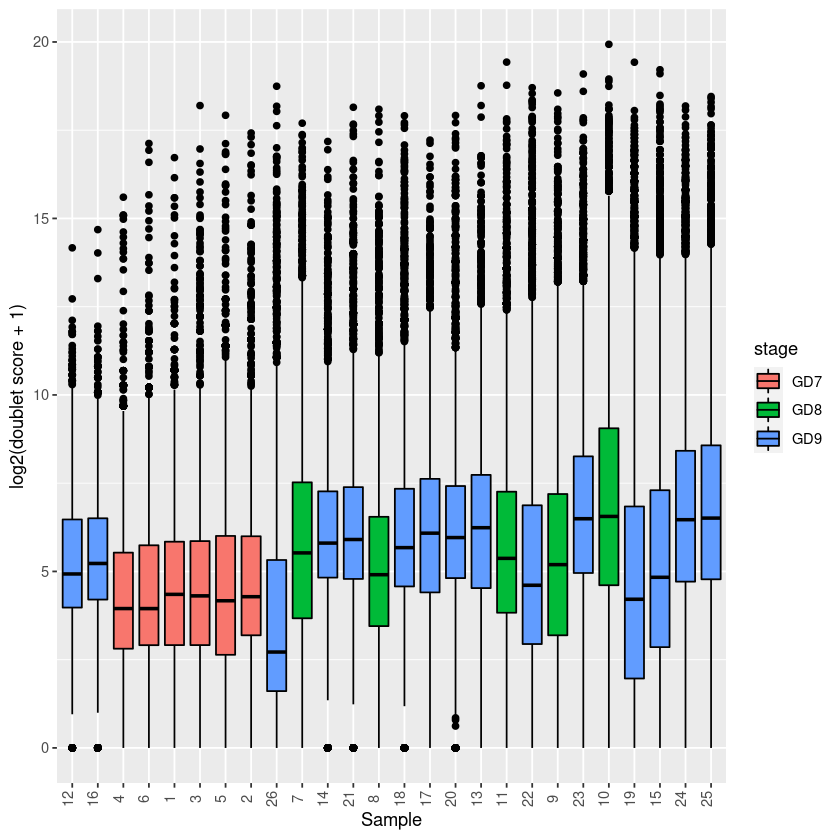

In [59]:
sampsize = melt(table(meta$sample))
order = order(sampsize$value, decreasing = FALSE)

# plot the doublet score per sample, to see if certain samples have higher than expected scores
# doublet score trends up when the number of cells input into the 10X chromium increases, in line with cell collision expected
ggplot(data.frame(score = log2(scores+1), sample = meta$sample, stage = meta$stage), aes (x = factor(sample, levels = sampsize$Var1[order]), y = score, fill = stage)) +
  geom_boxplot(col = "black") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.05)) +
  labs(y = "log2(doublet score + 1)", x = "Sample")
  # labs(y = "log2(doublet score + 1)", x = "Sample") +
  # scale_fill_manual(values = stage_colours, labels = stage_labels, name = "Stage")

Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'testVar' is deprecated.
See help("Deprecated")”
Cache found

Number of highly variable genes: 4043

Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'testVar' is deprecated.
See help("Deprecated")”
Cache found

Number of highly variable genes: 4536

Warning messag

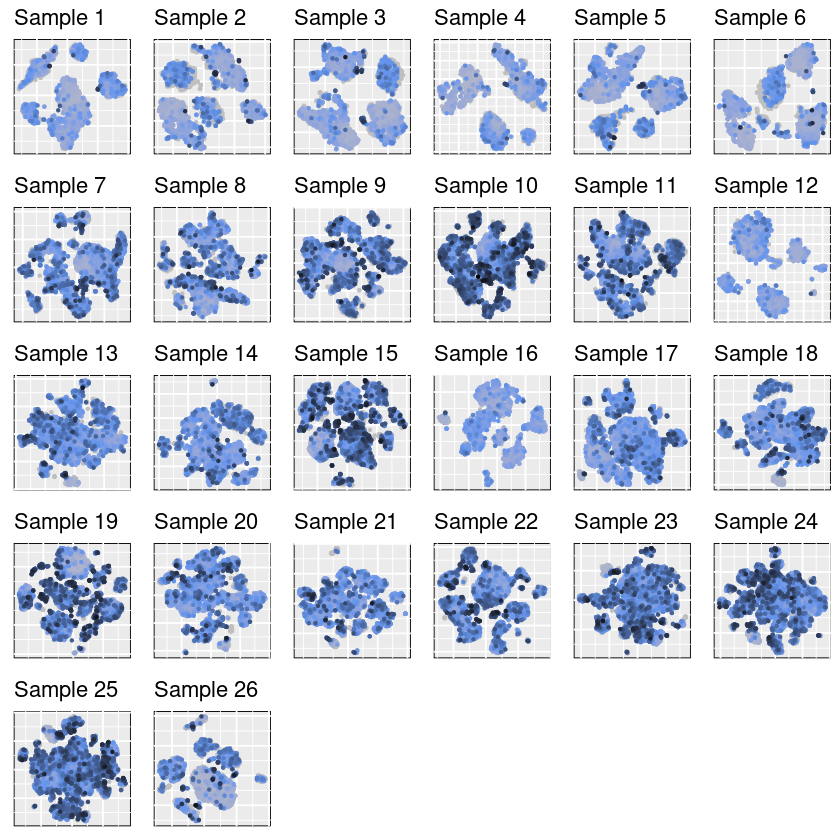

In [5]:
# here the code adapted from Pijuan-Sala et al. 2019 clusters the cells to find subclusters that are disproportionately doublets indiciate a cluster of doublet cells#
tsnes = lapply(unique(meta$sample), function(x){
  sub = scater::normalize(sce[, meta$sample == x])
  hvgs = getHVGs(sub)
  pca = prcomp_irlba(t(logcounts(sub[hvgs,])), n = 50)
  tsne = Rtsne(pca$x, pca = FALSE)
  return(tsne$Y)
})

names(tsnes) = unique(meta$sample)

colmax = max(log2(scores + 1))

score_plots = lapply(unique(meta$sample), function(x){
  
  scr = log2(scores[meta$sample == x] + 1)
  ord = order(scr)
  p = ggplot(as.data.frame(tsnes[[as.character(x)]])[ord,],
         aes(x = V1, y= V2, col = scr[ord])) +
    geom_point(size = 0.6) +
    scale_color_gradient2(name = "log2(score+1)", mid = "cornflowerblue", low = "gray75", high = "black", midpoint = max(colmax)/2) +
    # scale_color_viridis() +
    ggtitle(paste0("Sample ", x)) +
    theme(legend.position = "none",
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          axis.text = element_blank(),
          axis.title = element_blank(),
          panel.background = element_rect(colour = "black", linetype = 1, size = 0.5))
  
  return(p)
})
# this returns the plots with darker colour indicating higher doublet scores
plot_grid(plotlist = score_plots)

Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning m

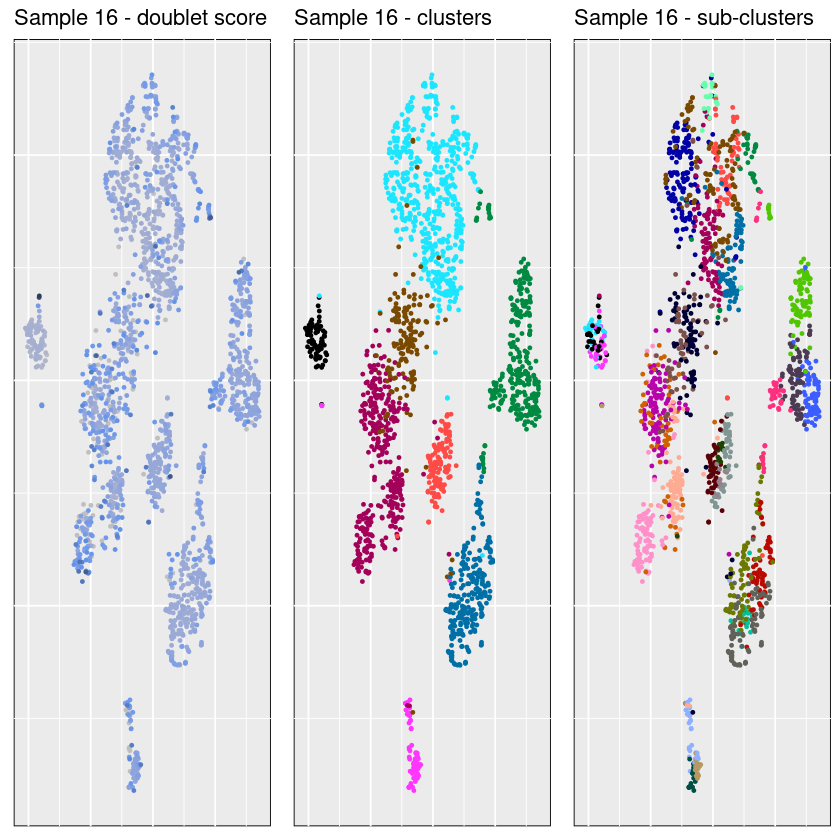

In [6]:
clusters = lapply(unique(meta$sample), function(x){
  sub_sce = scater::normalize(sce[,meta$sample == x])
  sub_meta = meta[meta$sample == x,]

  graph = buildSNNGraph(sub_sce)
  clusters = cluster_louvain(graph)

  vec = as.numeric(membership(clusters))
  names(vec) = sub_meta$cell
  return(vec)
})

names(clusters) = unique(meta$sample)
clusters_sub = lapply(unique(meta$sample), function(x){
  sub_sce = scater::normalize(sce[,meta$sample == x])
  sub_meta = meta[meta$sample == x,]
  clusts = clusters[[as.character(x)]]

  sub_clusts = lapply(unique(clusts), function(y){
    sub_sub_sce = scater::normalize(sub_sce[,clusts == y])
    sub_sub_meta = sub_meta[clusts == y,]

    graph = buildSNNGraph(sub_sub_sce, d = min(c(ncol(sub_sub_sce)-1, 50)))
    clusters = cluster_louvain(graph)

    vec = as.numeric(membership(clusters))
    vec = paste0(y, ".", vec)
    names(vec) = sub_sub_meta$cell
    return(vec)
  })

  clusts = do.call(c, sub_clusts)
  clusts = clusts[match(meta$cell[meta$sample == x], names(clusts))]
  return(clusts)
})

clusters = do.call(c, clusters)
clusters_sub = do.call(c, clusters_sub)
clusters = clusters_sub
meta$doub.density = scores


sample = 16

ord = order(scores[meta$sample == sample])
p1 = ggplot(as.data.frame(tsnes[[as.character(sample)]])[ord,], aes(x = V1, y= V2, col = log2(scores[meta$sample == sample]+1)[ord])) +
  geom_point(size = 0.7) +
  ggtitle(paste0("Sample ", sample, " - doublet score")) +
    theme(legend.position = "none",
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          axis.text = element_blank(),
          axis.title = element_blank(),
          panel.background = element_rect(colour = "black", linetype = 1, size = 0.5)) +
  # scale_color_viridis() +
  scale_color_gradient2(name = "log2(score+1)", mid = "cornflowerblue", low = "gray75", high = "black", midpoint = max(log2(scores[meta$sample == 23]+1))/2)

col2 = regmatches(clusters[meta$sample == sample], regexpr("[0-9]+", clusters[meta$sample == sample]))

p2 = ggplot(as.data.frame(tsnes[[as.character(sample)]])[ord,], aes(x = V1, y= V2, col = factor(col2)[ord])) +
  geom_point(size = 0.7) +
  ggtitle(paste0("Sample ", sample, " - clusters")) +
    theme(legend.position = "none",
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          axis.text = element_blank(),
          axis.title = element_blank(),
          panel.background = element_rect(colour = "black", linetype = 1, size = 0.5)) +
  scale_colour_Publication()

p3 = ggplot(as.data.frame(tsnes[[as.character(sample)]])[ord,], aes(x = V1, y= V2, col = factor(clusters[meta$sample == sample])[ord])) +
  geom_point(size = 0.7) +
  ggtitle(paste0("Sample ", sample, " - sub-clusters")) +
    theme(legend.position = "none",
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          axis.text = element_blank(),
          axis.title = element_blank(),
          panel.background = element_rect(colour = "black", linetype = 1, size = 0.5)) +
  scale_colour_Publication()

plot_grid(p1, p2, p3, nrow = 1)

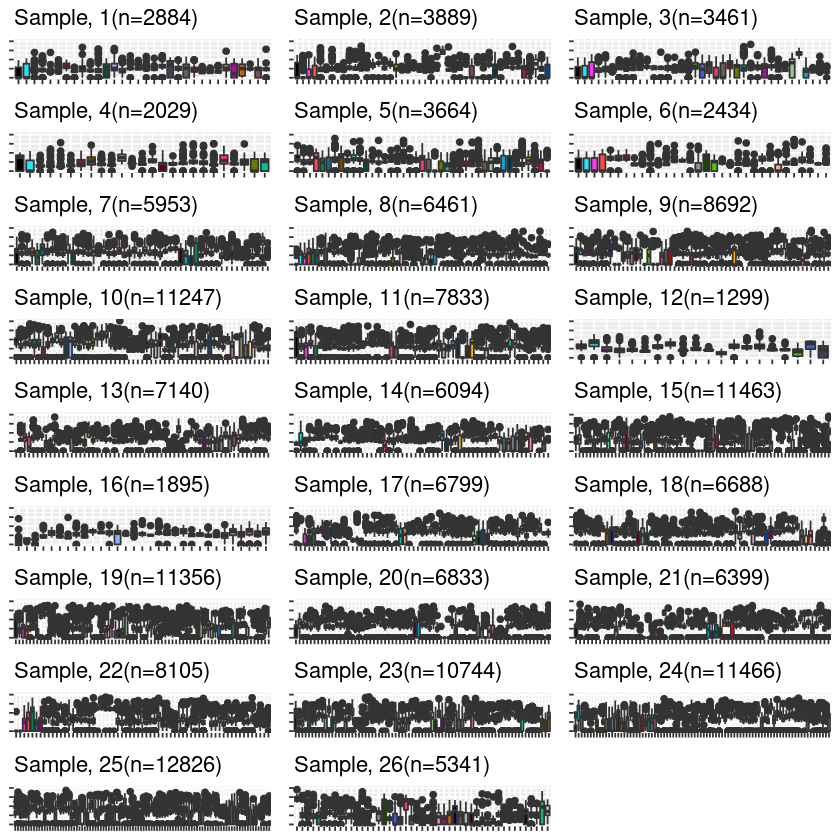

In [7]:
maxscore = max(log2(scores+1))

plots = lapply(unique(meta$sample), function(x){
  
  p = ggplot(data = data.frame(clusts = clusters[meta$sample == x],
                           scores = log2(scores[meta$sample == x] + 1)),
         mapping = aes(x = factor(clusts), y=scores, fill = factor(clusts))) +
    geom_boxplot() +
    theme(axis.text = element_blank(),
          axis.title = element_blank(),
          legend.position = "none") +
    lims(y = c(0, maxscore)) +
    scale_fill_Publication() +
    ggtitle(paste0("Sample, ", x, "(n=", sampsize$value[match(x, sampsize$Var1)], ")"))
  
  return(p)
})

plot_grid(plotlist = plots, ncol = 3)

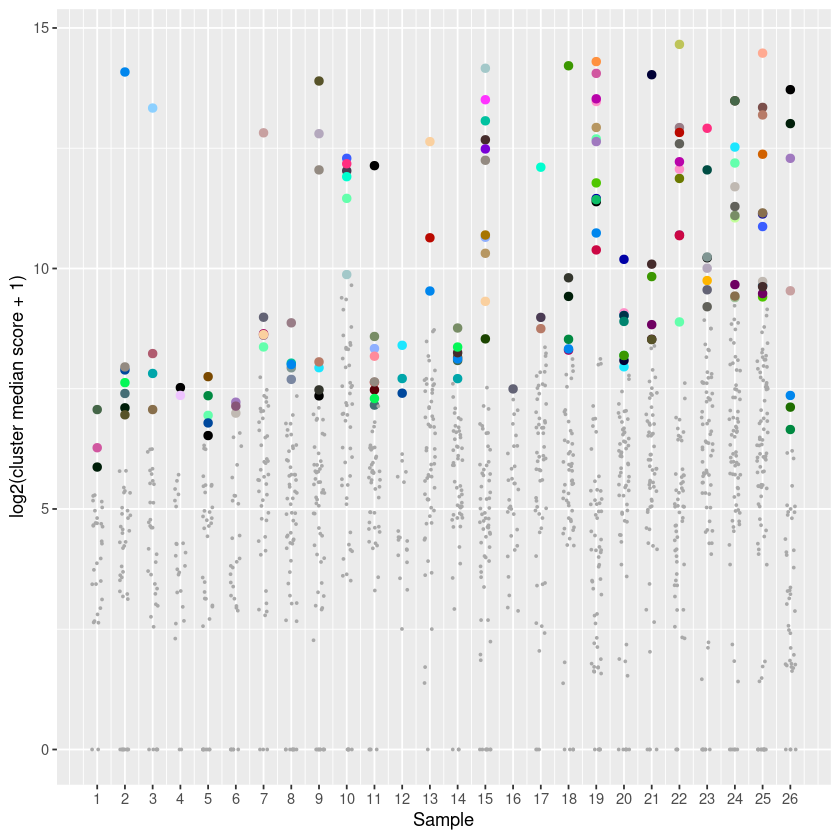

In [8]:
pdf = aggregate(meta$doub.density, list(meta$sample, clusters), median)

names(pdf) = c("sample", "cluster", "median.score")

mad_upper = function(x){
  x = x-median(x)
  return(mad(x[x>0], center = 0))
}

tests = lapply(unique(meta$sample), function(x){
  sub = pdf[pdf$sample == x,]
  scores_sample = meta$doub.density[meta$sample == x]
  sub$p.value = pnorm(sub$median.score, mean = median(sub$median.score), sd = mad_upper(sub$median.score), lower.tail = FALSE)
  return(sub)
})
pdf = do.call(rbind, tests)
pdf$fdr = p.adjust(pdf$p.value, method = "fdr")
pdf$n.cells = sapply(1:nrow(pdf), function(row){
  sum(clusters == pdf$cluster[row] & meta$sample == pdf$sample[row])
})

pdf$frac.cells = sapply(1:nrow(pdf), function(row){
  pdf$n.cells[row]/sum(pdf$n.cells[pdf$sample == pdf$sample[row]])
})



ggplot(pdf, aes(x = sample, y = log2(median.score + 1), col = factor(cluster))) +
  geom_point(data = pdf[pdf$fdr < 0.1,], size = 2) +
  geom_jitter(data = pdf[pdf$fdr >= 0.1,], col = "darkgrey", size = 0.4, width = 0.2, height = 0) +
  scale_colour_Publication() +
  theme(legend.position = "none") +
  scale_x_continuous(breaks = 1:max(pdf$sample)) +
  labs(x = "Sample", y = "log2(cluster median score + 1)")

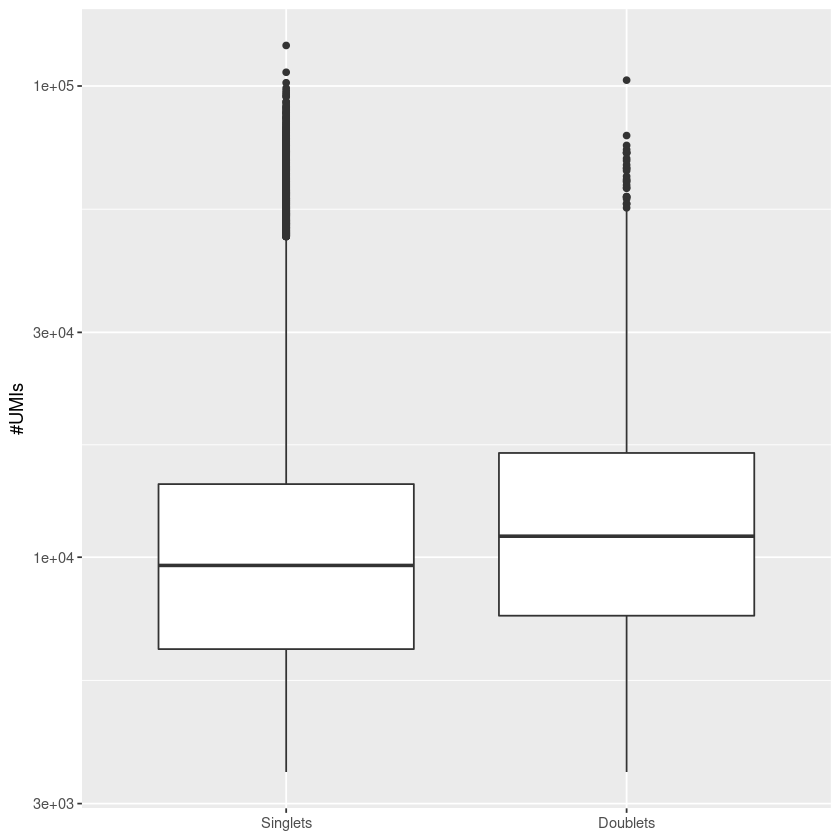

In [9]:
doub.call = paste(meta$sample, clusters) %in% paste(pdf$sample, pdf$cluster)[pdf$fdr < 0.1]

libs = Matrix::colSums(counts(sce))

#doublets have a higher UMI count on the fact that they're two cells' transcripts
ggplot(mapping = aes(x = doub.call, y = libs)) +
  geom_boxplot() +
  scale_x_discrete(labels = c("FALSE" = "Singlets", "TRUE" = "Doublets")) +
  theme(axis.title.x = element_blank()) +
  labs(y = "#UMIs") +
  scale_y_log10()

In [15]:
hvgs = getHVGs(sce)

pca = prcomp_irlba(t(logcounts(sce)[hvgs,]), n = 50)
hvgs = getHVGs(sce)

#get order: oldest to youngest; most cells to least cells
order_df = meta[!duplicated(meta$sample), c("stage", "sample")]
order_df$ncells = sapply(order_df$sample, function(x) sum(meta$sample == x))
order_df$stage = factor(order_df$stage, 
                        levels = rev(c("GD9", 
                                   "GD8", 
                                   "GD7")))
order_df = order_df[order(order_df$stage, order_df$ncells, decreasing = TRUE),]
order_df$stage = as.character(order_df$stage)


Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'testVar' is deprecated.
See help("Deprecated")”
Cache found

Number of highly variable genes: 5695

Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'testVar' is deprecated.
See help("Deprecated")”
Cache found

Number of highly variable genes: 5695



In [7]:
#gene_df is the cellranger gene table
getHVGs <- function(sce, min.mean = 1e-3, sparse_matrix = FALSE){
 if(sparse_matrix == FALSE){
   trend  <- scran::trendVar(sce, use.spikes = FALSE, loess.args = list(span = 0.05))
 }else{
   trend  <- scran::trendVar(sce, loess.args = list(span = 0.05))
 }
 decomp <- scran::decomposeVar(sce, fit = trend)
 decomp <- decomp[decomp$mean > min.mean,]
 rabbit_ensembl = biomaRt::useMart("ensembl", dataset="ocuniculus_gene_ensembl")
 gene_map <- getBM(attributes=c("ensembl_gene_id",  "chromosome_name"), values = genes, mart = rabbit_ensembl)
 decomp$FDR <- p.adjust(decomp$p.value, method = "fdr")
 out        <- rownames(decomp)[decomp$p.value < 0.05]
 message("Number of highly variable genes: ",length(out))
 return(out)
}

In [12]:
# make sure batchelor & dependencies are updated

all_correct = doBatchCorrect(counts = logcounts(sce)[rownames(sce) %in% hvgs,], 
                             timepoints = meta$stage, 
                             samples = meta$sample, 
                             timepoint_order = order_df$stage, 
                             sample_order = order_df$sample, 
                             npc = 50)
## Warning in (function (jobs, X, centers, info, k, query, get.index,
## get.distance) : tied distances detected in nearest-neighbor calculation
## Warning in (function (jobs, X, centers, info, k, query, get.index,
## get.distance) : tied distances detected in nearest-neighbor calculation
tsne = Rtsne(all_correct, pca = FALSE)$Y

graph = buildSNNGraph(all_correct, d = NA, transposed = TRUE)
set.seed(42)
clusts = as.numeric(membership(cluster_louvain(graph)))
names(clusts) = meta$cell

Warning message:
“'pc.input=TRUE' and 'use.dimred=TRUE' are deprecated.
Use 'reducedMNN' instead.”
Warning message:
“'pc.input=TRUE' and 'use.dimred=TRUE' are deprecated.
Use 'reducedMNN' instead.”
Warning message:
“'pc.input=TRUE' and 'use.dimred=TRUE' are deprecated.
Use 'reducedMNN' instead.”
Warning message:
“'pc.input=TRUE' and 'use.dimred=TRUE' are deprecated.
Use 'reducedMNN' instead.”


In [12]:
#optional
save.image("/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/5_doublet/doublet.RData")

In [4]:
#optional
load("/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/5_doublet/doublet.RData")

In [13]:
meta # with data on the doublet density of each cell

cell,barcode,sample,stage,batch,doub.density
<chr>,<chr>,<int>,<chr>,<int>,<dbl>
cell_1,AAACCCAAGCCTTCTC,1,GD7,1,6.367198
cell_2,AAACCCACACAATGAA,1,GD7,1,0.000000
cell_3,AAACCCACAGAATGTA,1,GD7,1,0.000000
cell_4,AAACCCAGTAGGTTTC,1,GD7,1,43.049333
cell_5,AAACCCATCTGGACTA,1,GD7,1,8.402787
cell_6,AAACGAAAGGTGAGAA,1,GD7,1,61.325550
cell_7,AAACGAAGTACCAATC,1,GD7,1,0.000000
cell_8,AAACGCTAGAAGCGGG,1,GD7,1,831.745600
cell_9,AAACGCTAGATGTAGT,1,GD7,1,94.302222


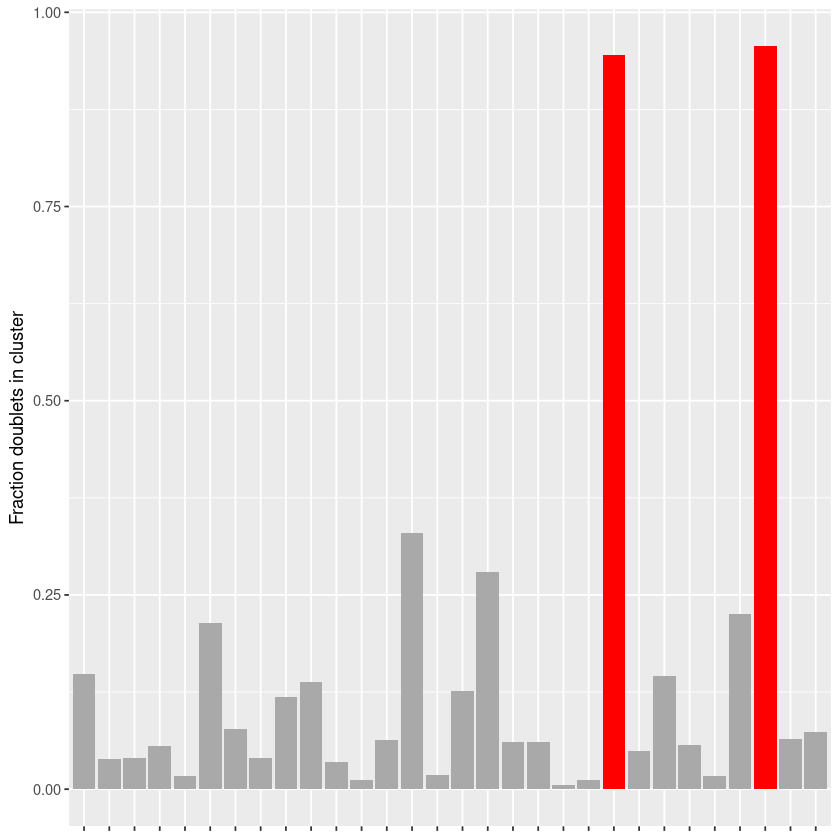

In [14]:
tab = table(clusts, doub.call)
tab = as.data.frame(sweep(tab, 1, rowSums(tab), "/"))
tab = tab[as.logical(tab$doub.call),c(1,3)]
tab$p = pnorm(tab$Freq, mean = median(tab$Freq), sd = mad_upper(tab$Freq), lower.tail = FALSE)
tab$fdr = p.adjust(tab$p, method = "fdr")

ggplot(mapping = aes(x = factor(rownames(tab), levels = rownames(tab)), y = tab[,2], fill = tab$fdr < 0.1)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = c("TRUE" = "red", "FALSE" = "darkgrey")) +
  theme(legend.position = "none", axis.text.x = element_blank(), axis.title.x = element_blank()) +
  labs(y = "Fraction doublets in cluster")

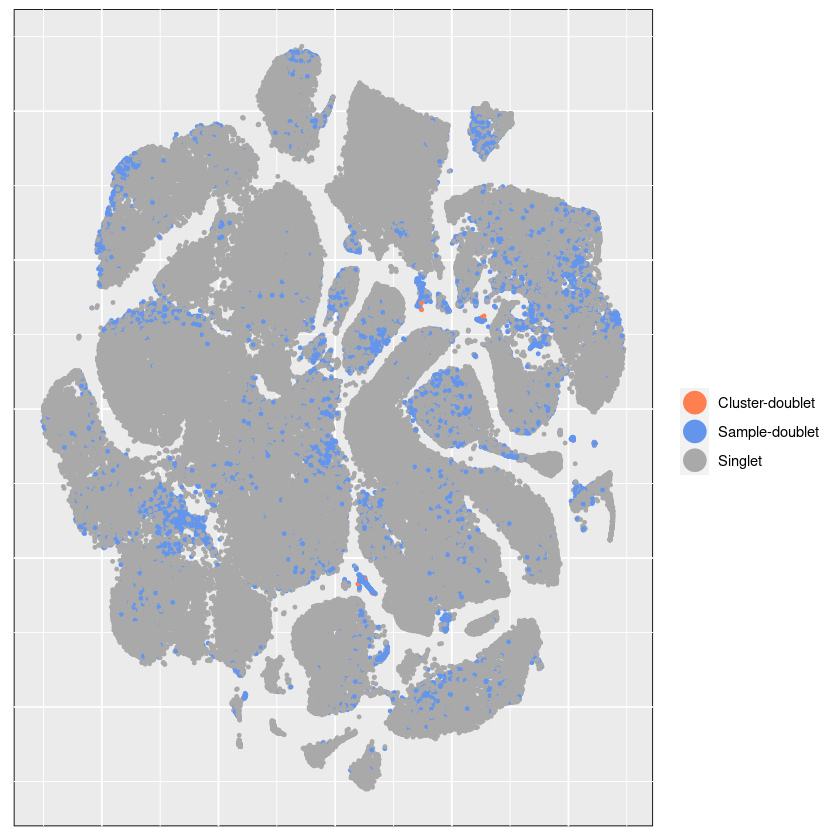

In [15]:
cluster_calls = clusts %in% tab$clusts[tab$fdr < 0.1]

cell_calls = doub.call
state = rep("Singlet", nrow(meta))
state[cluster_calls] = "Cluster-doublet"
state[cell_calls] = "Sample-doublet"

# ord = order(factor(state, levels = c("Singlet", "Cluster-doublet", "Sample-doublet")))
ord = sample(length(state), length(state))

ggplot(as.data.frame(tsne)[ord,], aes(x = V1, y= V2, col = state[ord])) +
    geom_point(size = 0.7) +
      theme(axis.line = element_blank(),
            axis.ticks = element_blank(),
            axis.text = element_blank(),
            axis.title = element_blank(),
            panel.background = element_rect(colour = "black", linetype = 1, size = 0.5)) +
    scale_colour_manual(values = c("Singlet" = "darkgrey", "Cluster-doublet" = "coral", "Sample-doublet" = "cornflowerblue"),
                        name = "") +
    guides(colour = guide_legend(override.aes = list(size=6)))

Warning message:
“Removed 170111 rows containing missing values (geom_point).”
Warning message:
“Removed 169106 rows containing missing values (geom_point).”
Warning message:
“Removed 169534 rows containing missing values (geom_point).”
Warning message:
“Removed 170966 rows containing missing values (geom_point).”
Warning message:
“Removed 169331 rows containing missing values (geom_point).”
Warning message:
“Removed 170561 rows containing missing values (geom_point).”
Warning message:
“Removed 167042 rows containing missing values (geom_point).”
Warning message:
“Removed 166534 rows containing missing values (geom_point).”
Warning message:
“Removed 164303 rows containing missing values (geom_point).”
Warning message:
“Removed 161748 rows containing missing values (geom_point).”
Warning message:
“Removed 165162 rows containing missing values (geom_point).”
Warning message:
“Removed 171696 rows containing missing values (geom_point).”
Warning message:
“Removed 165855 rows containing mis

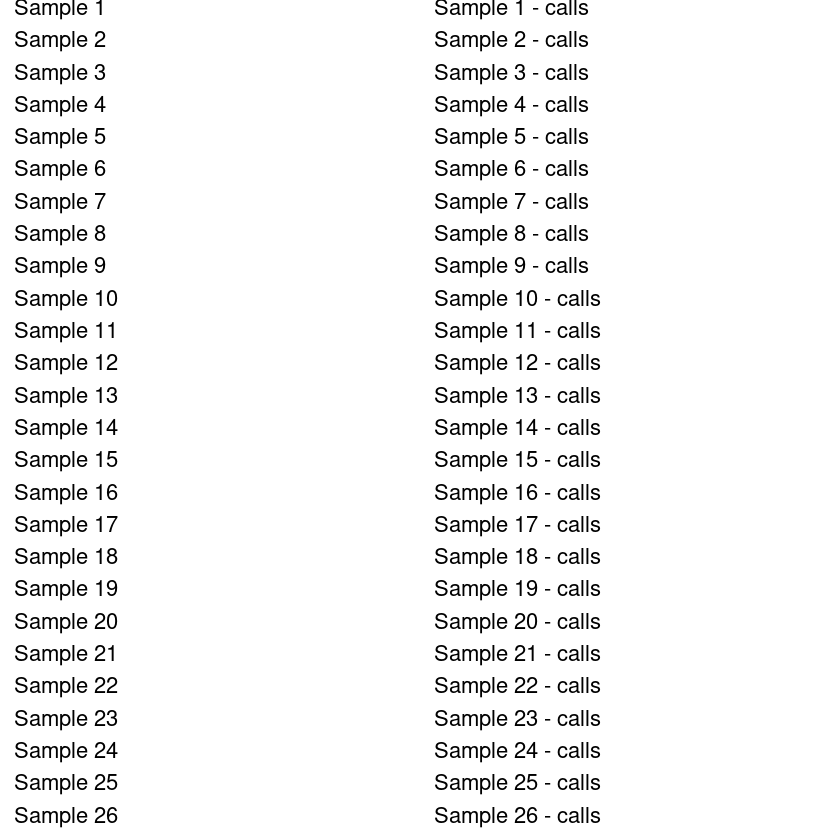

In [16]:
plots_calls = lapply(unique(meta$sample), function(x){
  keep = meta$sample == x
  ord = order(factor(state, levels = c("Singlet", "Cluster-doublet", "Sample-doublet")[keep]))
  state_sub = state[keep]
  ggplot(as.data.frame(tsnes[[as.character(x)]])[ord,], aes(x = V1, y= V2,
                                                                   col = state_sub[ord])) +
    geom_point(size = 0.7) +
    ggtitle(paste0("Sample ", x, " - calls")) +
      theme(legend.position = "none",
            axis.line = element_blank(),
            axis.ticks = element_blank(),
            axis.text = element_blank(),
            axis.title = element_blank(),
            panel.background = element_rect(colour = "black", linetype = 1, size = 0.5)) +
    scale_colour_manual(values = c("Singlet" = "darkgrey", "Cluster-doublet" = "coral", "Sample-doublet" = "cornflowerblue"))
})

grids = lapply(1:length(plots_calls), function(x) plot_grid(score_plots[[x]], plots_calls[[x]]))
grid = plot_grid(plotlist = grids, ncol =1)

plot(grid)


In [20]:
meta$doublet = state != "Singlet"

Cache found



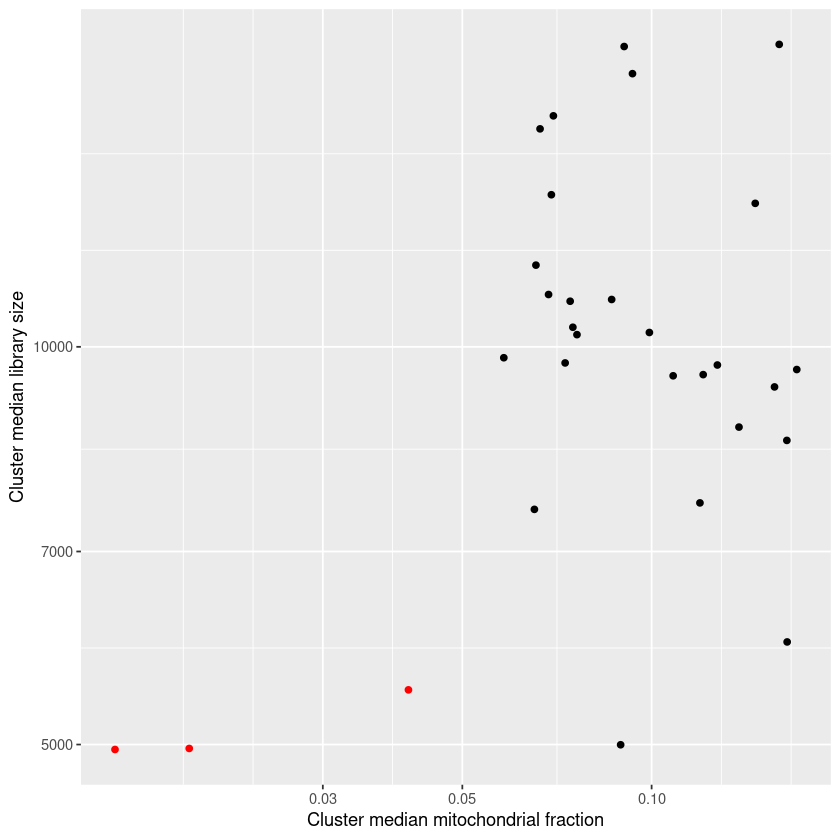

In [18]:
rabbit_ensembl = biomaRt::useMart("ensembl", dataset="ocuniculus_gene_ensembl")
gene_map = getBM(attributes=c("ensembl_gene_id", "chromosome_name"), values = genes[,1], mart = rabbit_ensembl)

mt.counts = counts(sce)[which(genes[,1] %in% gene_map$ensembl_gene_id[gene_map$chromosome_name=="MT"]), ]
mt.fraction = Matrix::colSums(mt.counts)/Matrix::colSums(counts(sce))
libsizes = Matrix::colSums(counts(sce))


meds = data.frame(mt = sapply(unique(clusts), function(x) median(mt.fraction[clusts == x])),
                  lib = sapply(unique(clusts), function(x) median(libsizes[clusts == x])),
                  cluster = unique(clusts))

meds$stripped = meds$mt < 0.05

#stripped cells have extremely low MT, indicating 'stripped' or nuclei only 
#discarded in the Pijuan-Sala et al. 2019 pipeline
                              
ggplot(meds, aes (x = mt, y = lib, col = stripped)) +
  geom_point() +
  labs(x = "Cluster median mitochondrial fraction",
       y = "Cluster median library size") +
  scale_x_log10() + 
  scale_y_log10() +
  theme(legend.position = "none") +
  scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black"))

In [19]:
meta$stripped = clusts %in% meds$cluster[meds$stripped]
#shows the number of cells called as doublets, which will be filtered out in later steps
kable(table(ifelse(meta$doublet, "Doublet", "Singlet"), meta$stage), caption = "Number of called doublets at each developmental timepoint.")
#shows the number of cells called as stripped, which will be filtered out in later steps
kable(table(ifelse(meta$stripped, "Stripped", "Normal"), meta$stage), caption = "Number of called stripped nuclei at each developmental timepoint.")




|        |   GD7|   GD8|    GD9|
|:-------|-----:|-----:|------:|
|Doublet |  1415|  2801|   8572|
|Singlet | 16946| 37385| 105876|



|         |   GD7|   GD8|    GD9|
|:--------|-----:|-----:|------:|
|Normal   | 14656| 37307| 106058|
|Stripped |  3705|  2879|   8390|

In [21]:
write.table(meta, file = "/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/5_doublet/meta.tab", sep = "\t", quote = FALSE, row.names = FALSE, col.names = TRUE)
save(list = ls(), file = "/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/5_doublet/debug.RData")

In [22]:
#summary statistics of the doublet and stripped QC and remaining cells
summary(meta)
length(meta$cell[which(meta$doublet == FALSE & meta$stripped ==FALSE)])

     cell             barcode              sample         stage          
 Length:172995      Length:172995      Min.   : 1.00   Length:172995     
 Class :character   Class :character   1st Qu.:10.00   Class :character  
 Mode  :character   Mode  :character   Median :17.00   Mode  :character  
                                       Mean   :15.67                     
                                       3rd Qu.:22.00                     
                                       Max.   :26.00                     
     batch    doub.density        doublet         stripped      
 Min.   :1   Min.   :      0.0   Mode :logical   Mode :logical  
 1st Qu.:1   1st Qu.:     11.7   FALSE:160207    FALSE:158021   
 Median :1   Median :     45.0   TRUE :12788     TRUE :14974    
 Mean   :1   Mean   :   1436.9                                  
 3rd Qu.:1   3rd Qu.:    185.3                                  
 Max.   :1   Max.   :1225923.0                                  

[1] 146133

In [23]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Scientific Linux 7.7 (Nitrogen)

Matrix products: default
BLAS:   /usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-5.4.0/r-3.6.1-zrytncqvsnw5h4dl6t6njefj7otl4bg4/rlib/R/lib/libRblas.so
LAPACK: /usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-5.4.0/r-3.6.1-zrytncqvsnw5h4dl6t6njefj7otl4bg4/rlib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] batchelor_1.2.4             knitr_1.28  